# Damage Library

This module provides a computational framework for constructing degrading models inspired by the hypothesis of @kachanov1958vremeni. A survey of the resulting theory is given by @krajcinovic1995continuum.


The complete implementation follows the approach described by @ngoc2017damage.
A notable implementation of a similar model is the `*CONCRETE DAMAGED PLASTICITY` model provided by the program ABAQUS, and based on the work of @lee1998plasticdamage.

The core concept is to take an existing *basis* model for a work-conjugate pair of variables, and construct a new model which progressively deteriorates the response of the basis model.

In the univariate case, it is postulated that degredation takes the form

$$
\begin{aligned}
\sigma &= (1 - d) \bar{\sigma} \\
E &= (1 - d) \bar{E}
\end{aligned}
$$


The internal variable, $d$, varies from $0$ to $1$ and evolves according to a *dissipation* rule that is defined by assigning an *accumulation* relation over an energy 
interval, $\{\psi_{d0}, \psi_{d1}\}$.

In [1]:
from damage import (
    # Submodules
    accumulation,
    dissipation ,
    # Wrapper
    FedeasUnivariateDamage
)
from opensees import uniaxial
from opensees.tcl import dumps

In [2]:
from opensees.units.english import ksi, psi, inch, ft
from numpy import sin, linspace, pi, sqrt

In [3]:
import matplotlib.pyplot as plt
plt.style.use("typewriter")

### Accumulation Rules

The `accumulation` submodule is a library of accumulation models. An accumulation object
has the following methods:

- ```.py
  AccumulationModel.getIndex(psi: float) -> DamageIndex
  ```
  where `DamageIndex` has scalar fields `y` and `dydx` containing the value and
  tangent, respectively, of the accumulation function at the given normalized
  energy, `psy`.

>**NOTE** This design uses a single method to return both the value and tangent
of the accumulation model. It may be preferable to change this for consistency with
the OpenSees style, where models have distinct `getResponse` and `getTangent` methods.



In [4]:
psi = linspace(0.01, 1., 100)

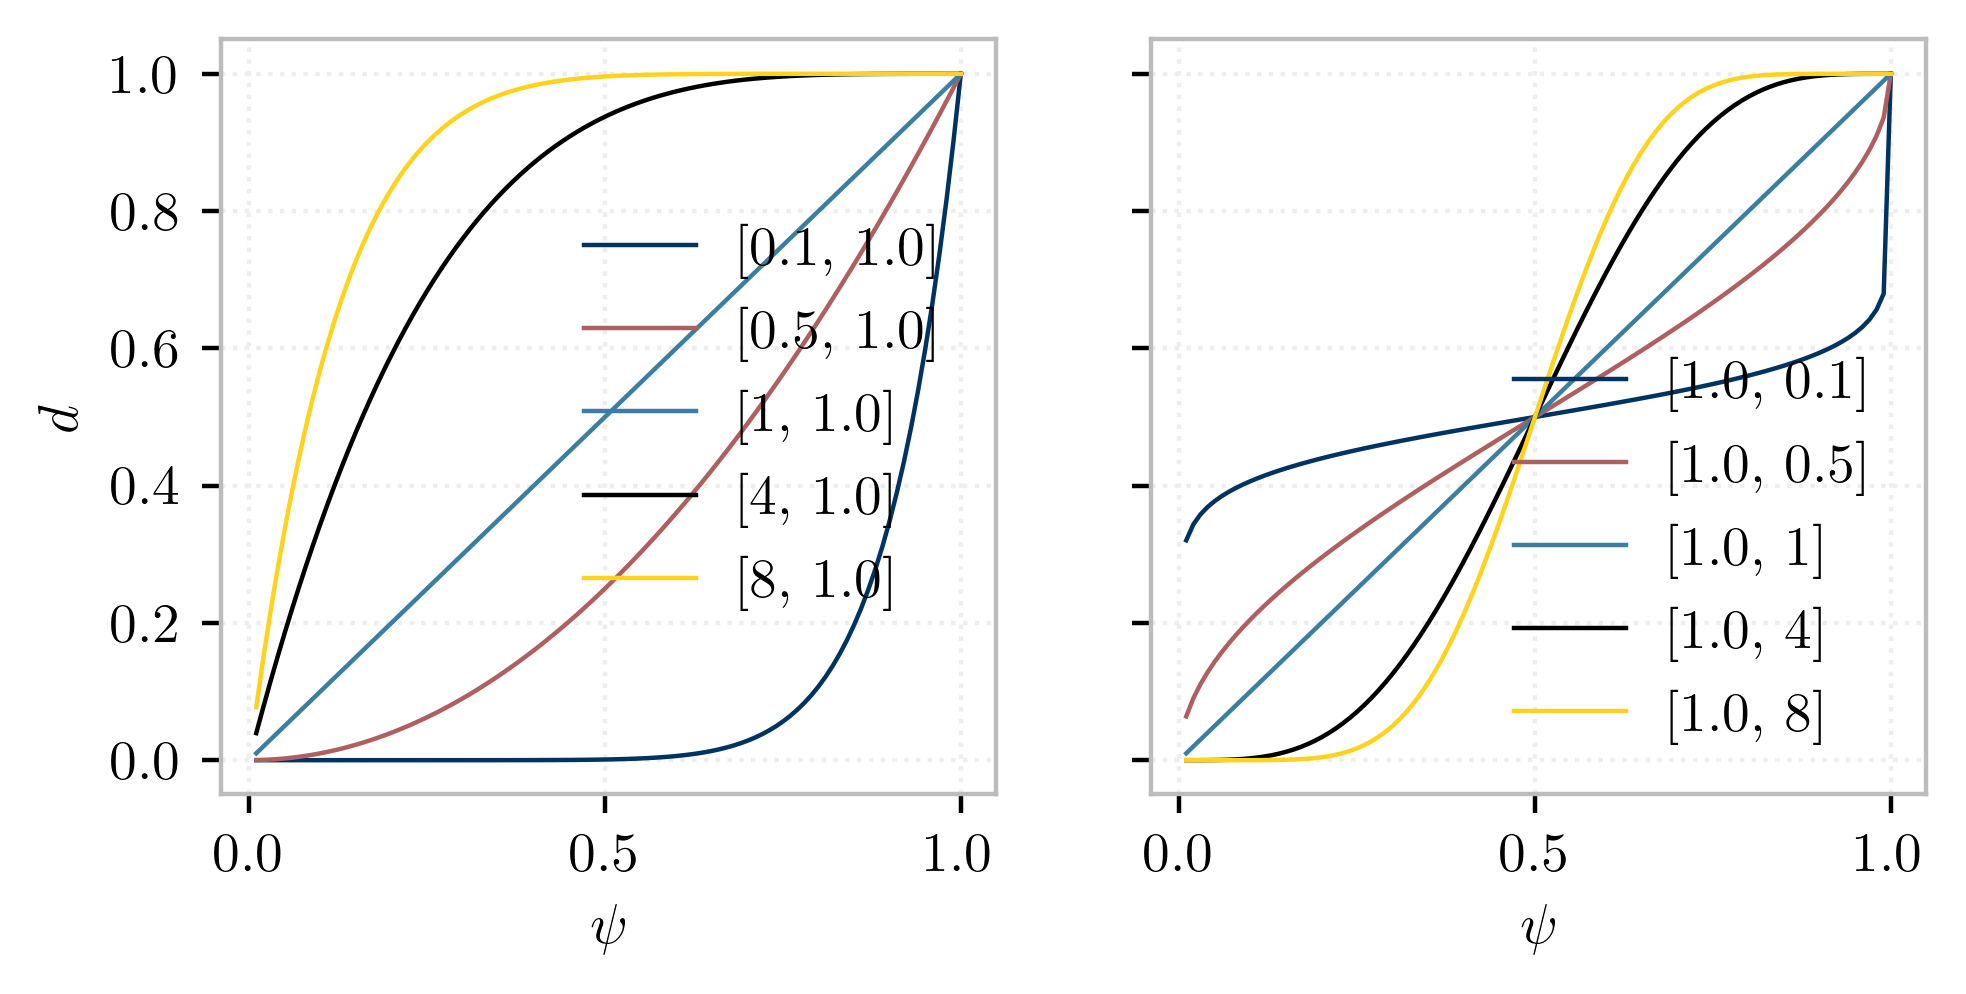

In [5]:
fig, axs = plt.subplots(1,2, figsize=(6.5,3.5),  sharey=True)

parameter_range = [0.1, 0.5, 1, 4, 8]
parameters = [None, None]

for i,ax in enumerate(axs):
    for param in parameter_range:
        parameters[i] = param
        parameters[not i] = 1.0
        a = accumulation.MBeta(None, parameters)
        ax.plot(psi, [a.getIndex(x).y for x in psi], label=f"{parameters}")
    ax.legend()
    # ax.axis("equal")
    ax.set_xlabel(r"$\psi$")
axs[0].set_ylabel(r"$d$");

### Dissipation

The `DirectionalTotal` dissipation rule specifies the maner in which energy is dissipated for a particular loading direction. This allows distinct strategies to be applied in tension and compression.

A directional dissipation rule can be defined in the following ways:

- `DirectionalTotal(accum, interval, )`




In [6]:
interval  = [3, 125]  # [Cd0, Cd1]
cycle     =  0.12   # Cwc
scale     = {"E": 29e6, "fy": 60e3}

In [7]:
# Directional Coupling
coupling  = [0.1, 0.1]    # Ccd

In [8]:
Fy  = 66.8*ksi             # steel yield stress
Es  = 29000.*ksi           # modulus of steel
Bs  = 0.005                # strain-hardening ratio 
R0  =  4                   # control the transition from elastic to plastic branches
cR1 = 0.925                # "
cR2 = 0.15                 # "

In [9]:
steel = uniaxial.Steel02(None, 60e3, 29e6, 0.05, R0=18)

In [10]:
a = accumulation.MBeta(1, [4.2, 1.])
d = dissipation.TotalStrain(a, interval, cycle, scale)
m = FedeasUnivariateDamage(2, steel,  d, 0.05)

uniaxialMaterial Steel02 1  60000.0  29000000.0  0.05  18  0.925  0.15 
import  /home/claudio/packages/libdmg/bin/libdmg.so 
dmg::evol mbeta 1   4.2  1.0 
dmg::load Uni 1 -evol 1 -Cd0 3 -Cd1 125 -Cwc 0.12 -E 29000000.0 -fy 60000.0 
dmg::wrap 1d 2  1  1 -Ccd 0.05 
uniaxialMaterial FedeasUniaxialDamage 2  1 -damage 2 



#libdmg::Debug -- libdmg version '0.0.1' successfully loaded.
#libdmg::Debug -- new 'mbeta' damage evolution with tag '1', dp=[4.200000, 1.000000, ]
#libdmg::Debug -- new damage loading with tag '1'
#libdmg::Debug -- creating uniaxial wrapper
#libdmg::Debug -- new '1d' damage wrapper with tag '2' at '0x55f31a2b7ed0'
#libdmg::Debug -- found map of tagged wrappers.
#Set damage wrapper '2'


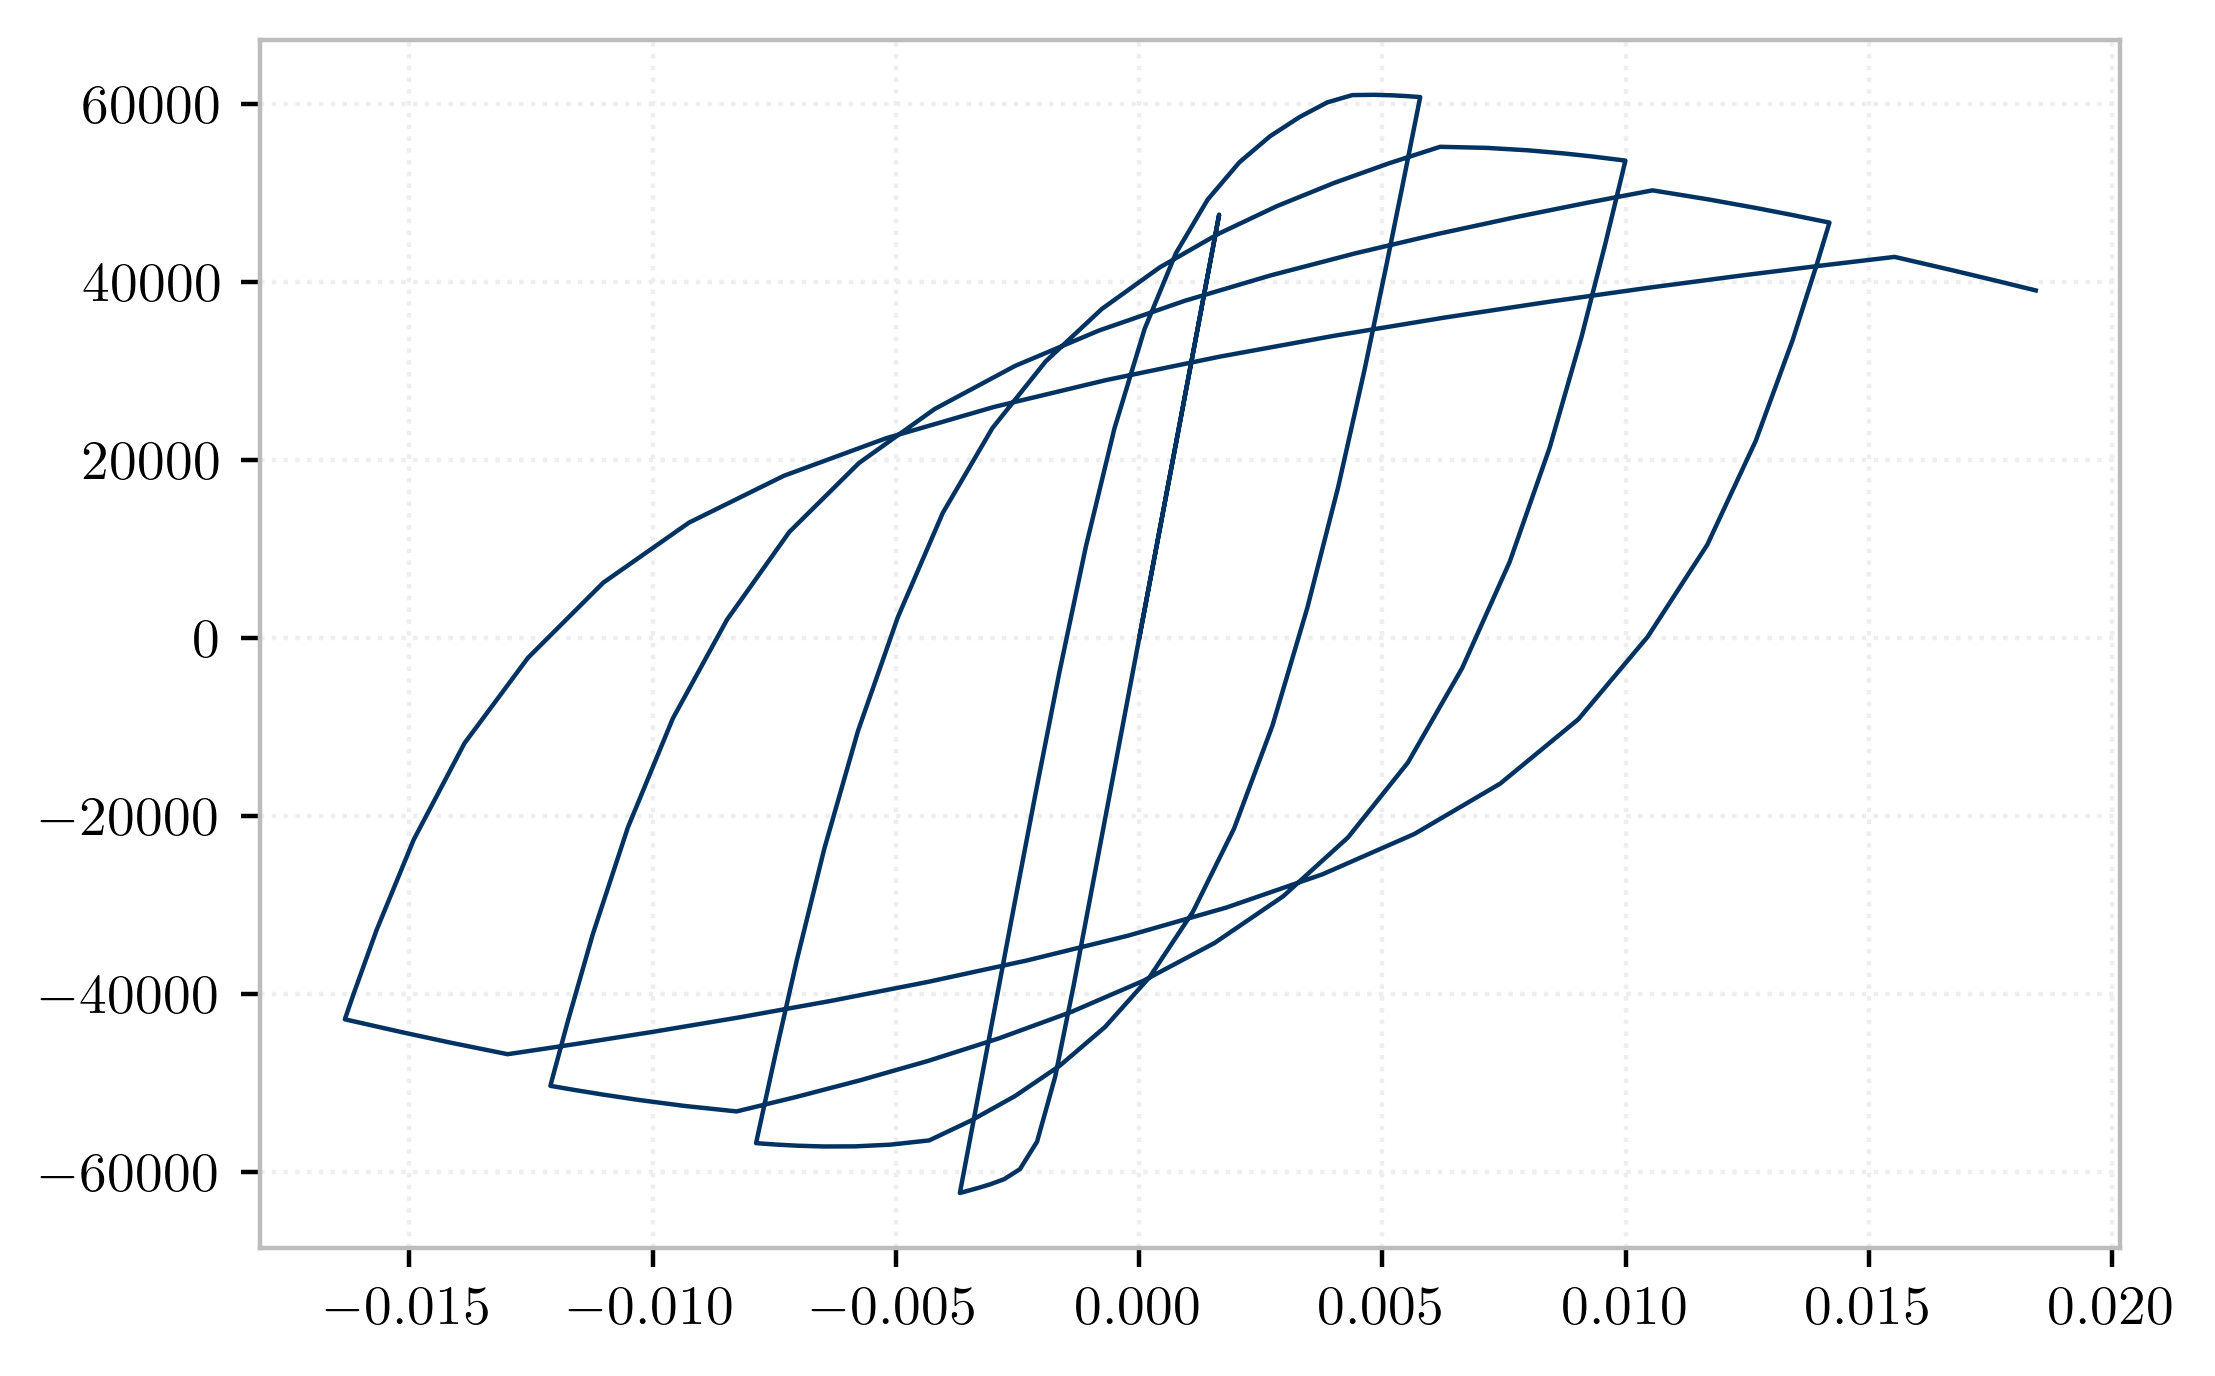

In [11]:
print(dumps(m))

n = 200
strain = Fy/Es*sin(linspace(0, 8.5*pi, n))*linspace(0.2, 8.0, n)
with m as mat:
    plt.plot(strain, [mat.getStress(e, commit=True) for e in strain])

## Examples

In [12]:
a = accumulation.MBeta(1, [4.2, 1.])
d = dissipation.TotalStrain(a, interval, cycle, scale)

#libdmg::Debug -- libdmg version '0.0.1' successfully loaded.
#libdmg::Debug -- new 'mbeta' damage evolution with tag '1', dp=[4.200000, 1.000000, ]
#libdmg::Debug -- new damage loading with tag '1'
#libdmg::Debug -- creating uniaxial wrapper
#libdmg::Debug -- new '1d' damage wrapper with tag '1' at '0x55f31b8053a0'
#libdmg::Debug -- found map of tagged wrappers.
#Set damage wrapper '1'
#libdmg::Debug -- libdmg version '0.0.1' successfully loaded.
#libdmg::Debug -- new 'mbeta' damage evolution with tag '1', dp=[4.200000, 1.000000, ]
#libdmg::Debug -- new damage loading with tag '1'
#libdmg::Debug -- creating uniaxial wrapper
#libdmg::Debug -- new '1d' damage wrapper with tag '1' at '0x55f31b8041d0'
#libdmg::Debug -- found map of tagged wrappers.
#Set damage wrapper '1'
#libdmg::Debug -- libdmg version '0.0.1' successfully loaded.
#libdmg::Debug -- new 'mbeta' damage evolution with tag '1', dp=[4.200000, 1.000000, ]
#libdmg::Debug -- new damage loading with tag '1'
#libdmg::Debug -- cre

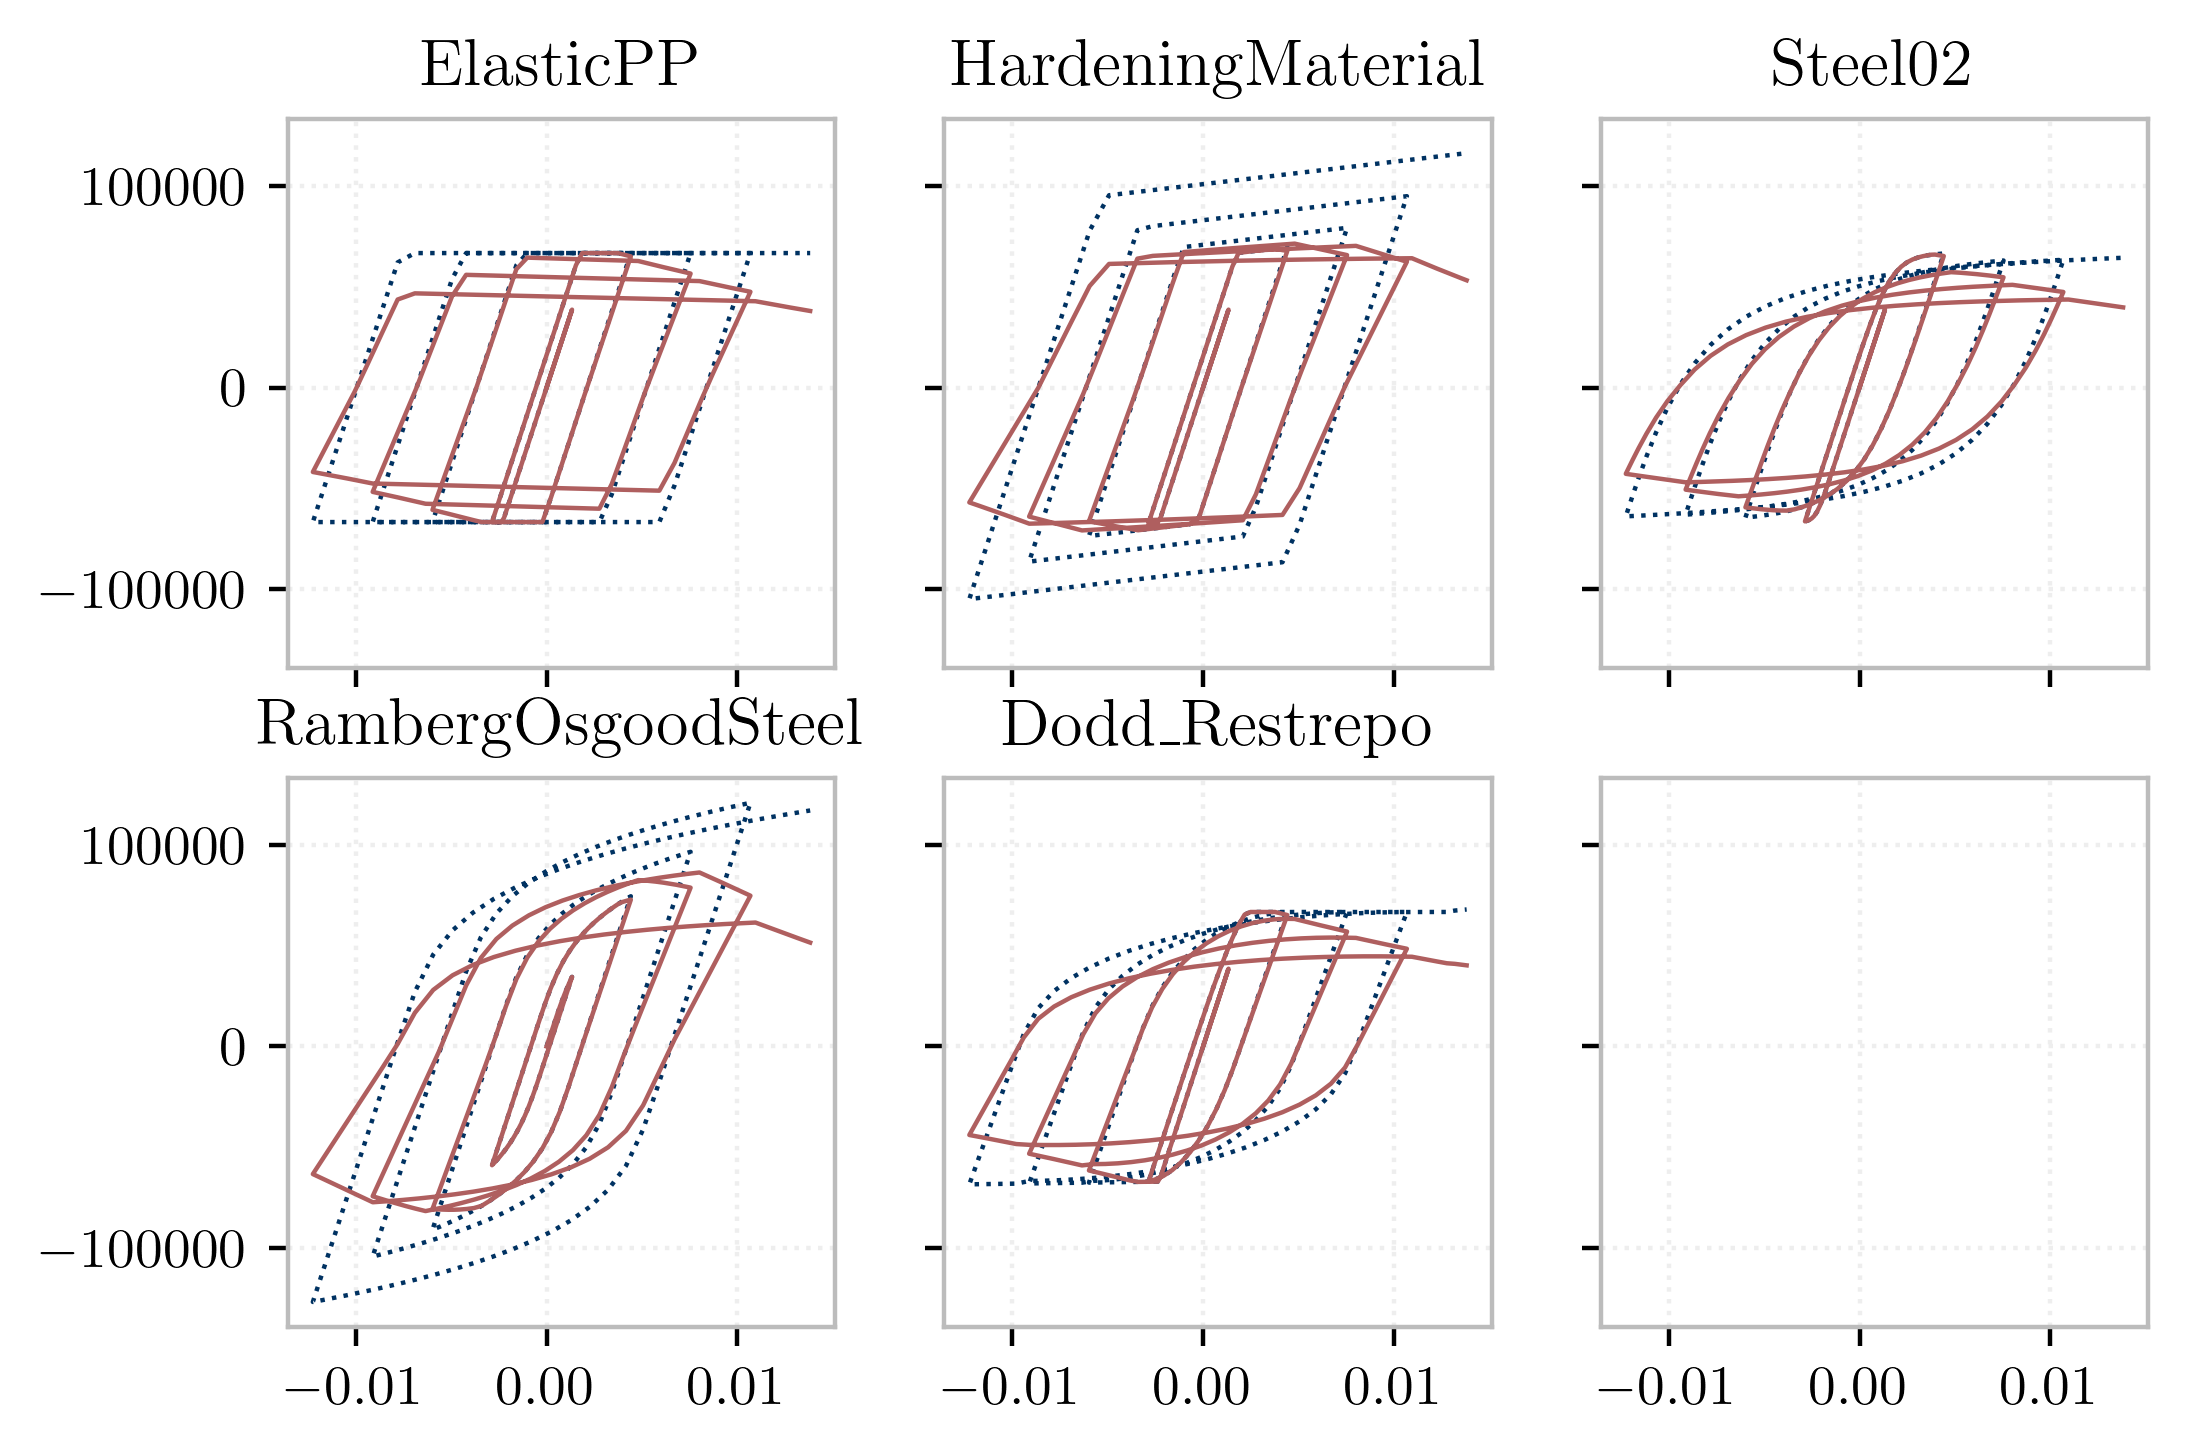

In [13]:
n = 300
strain = Fy/Es*sin(linspace(0, 8.5*pi, n))*linspace(0.2, 6.0, n)

fig, ax = plt.subplots(2,3, sharey=True, sharex=True)

esh, esu = 10*Fy/Es, 14*Fy/Es
eshi = (esu + 5*esh)/5
materials = [
    uniaxial.ElasticPP(None, Es, Fy/Es),
    uniaxial.Hardening(None, Es, Fy, 0.02*Es, 0.02*Es),
    uniaxial.Steel02(None, Fy, Es, Bs, 18.),
    uniaxial.RambergOsgoodSteel(None, Fy, Es, 0.002, 4),
    uniaxial.DoddRestrepo(None, Fy, 1.2*Fy, esh, esu, Es, eshi, 1.1*Fy),
]



for i,base in enumerate(materials):
    with base as steel:
        ax[i//3, i%3].plot(strain, [steel.getStress(e, commit=True) for e in strain], ":", label="base")
        ax[i//3, i%3].set_title(base.__class__.__name__)

    with FedeasUnivariateDamage(2, base, d, 0.05) as steel:
        ax[i//3, i%3].plot(strain, [steel.getStress(e, commit=True) for e in strain])


# uniaxial.Bond_SP01(1, Fy, Sy=1.0, Fu=1.4*Fy, Su=, b=, R=)

# ax.set_xlabel(r"$\varepsilon$")
# ax.set_ylabel(r"$\sigma$")
# ax.legend(); 